# Explore example datasets

We provide the option to download subsets of existing open datasets with opportunistic sensor data. In this notebook we present these datasets and their subsets.

In [1]:
import matplotlib.pyplot as plt

import poligrain as plg

## OpenMRG

The data is downloaded from https://github.com/OpenSenseAction/opensense_example_data/tree/main/OpenMRG

This is based on the OpenMRG dataset described in Andersson et al. (2022) https://doi.org/10.5194/essd-14-5411-2022

Currently there are two different subsets:
- `'5min_2h'`: 2.5 hours of data, all sensors aggregated to 5 minutes temporal resolution
- `'8d'`: 8 days of data from the OpenMRG project (default subset). The CML data is processed using radar data as wet-dry indicator with `pycomlink`.

For details of how the data was generated see the notebook in the example data repo linked above.


In [2]:
(
    ds_rad,
    ds_cmls,
    ds_gauges_municp,
    ds_gauge_smhi,
) = plg.example_data.load_openmrg(data_dir="example_data", subset="8d")

File already exists at example_data/openmrg_cml_8d.nc
Not downloading!
File already exists at example_data/openmrg_rad_8d.nc
Not downloading!
File already exists at example_data/openmrg_municp_gauge_8d.nc
Not downloading!
File already exists at example_data/openmrg_smhi_gauge_8d.nc
Not downloading!


Compare hourly rainfall sums of one CML and one gauge. Note that these are just two randomly chosen IDs of CML and gauge for illustration purposese. 

Check out the notebook on finding neighboring gauges for CMLs to learn how to find the closest gauge for a CML.

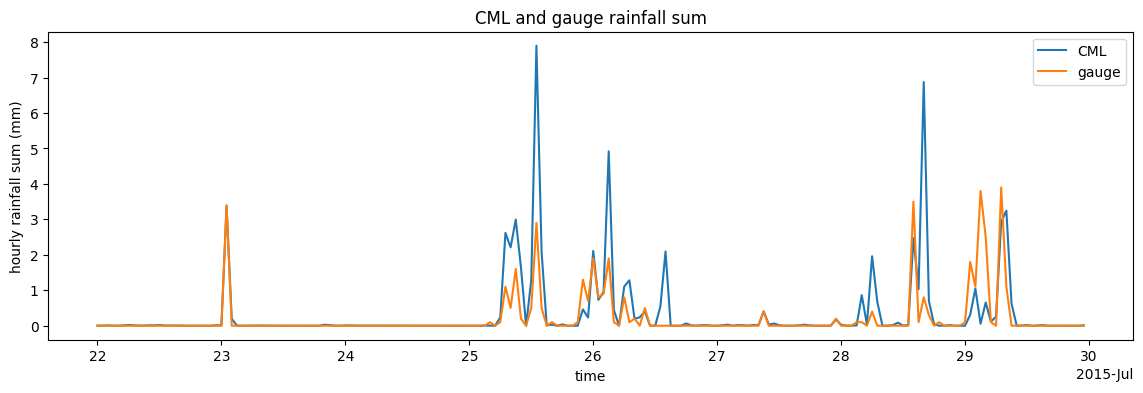

In [3]:
ds_cml = ds_cmls.isel(cml_id=1, sublink_id=0)
ds_cml.R.resample(time="1h").mean().plot(figsize=(14, 4), label="CML")
ds_gauges_municp.isel(id=0).rainfall_amount.resample(time="1h").sum().plot(
    label="gauge"
)
plt.legend()
plt.ylabel("hourly rainfall sum (mm)")
plt.title("CML and gauge rainfall sum");

Plot rainfall accumulation for all CMLs (in blue) and the ten city gauges (in black). 

This shows that, besides some CML outliers, the rainfall accumulation is in the same range.

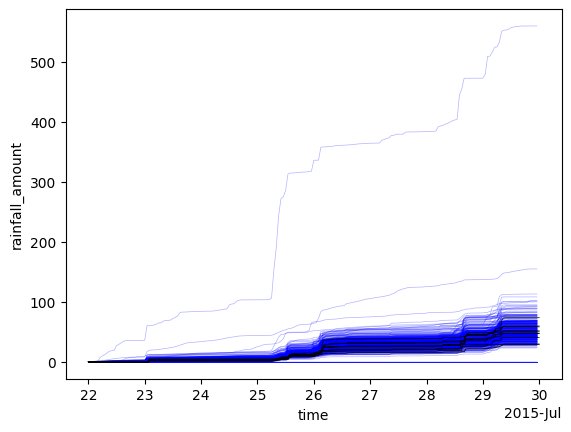

In [4]:
ds_cmls.isel(sublink_id=0).R.resample(time="1h").mean().cumsum(dim="time").plot.line(
    x="time", color="b", linewidth=0.5, alpha=0.3, add_legend=False
)
ds_gauges_municp.rainfall_amount.cumsum(dim="time").plot.line(
    x="time", color="k", linewidth=0.5, add_legend=False
);

Plot rainfall sum over the full 8 days for all sensors (radar, CML, city gauges) on a map.

<Axes: xlabel='lon', ylabel='lat'>

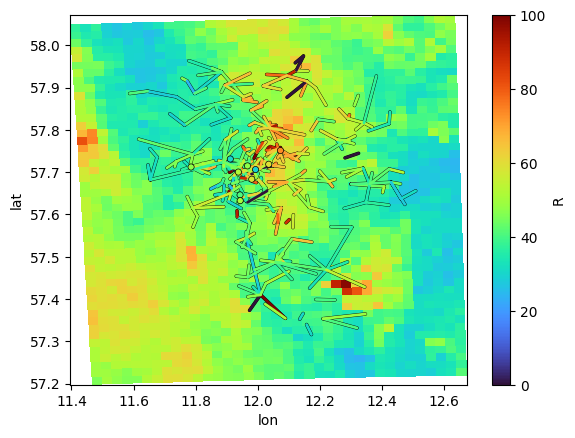

In [5]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.isel(sublink_id=0).R.resample(time="1h").mean().sum(dim="time"),
    da_grid=ds_rad.R.resample(time="1h").mean().sum(dim="time"),
    da_gauges=ds_gauges_municp.rainfall_amount.sum(dim="time"),
    vmin=0,
    vmax=100,
)

## OpenRainER

This is a subset of the OpenRainER dataset available at downloads the dataset available on Zenodo https://doi.org/10.5281/zenodo.10593848

Note that the CML processing is currently being worked on. Hence, there is no CML rainfall data in this example yet.

In [6]:
(
    ds_rad,
    ds_cmls,
    ds_gauges,
) = plg.example_data.load_openrainer(data_dir="example_data", subset="8d")

File already exists at example_data/openrainer_cml_8d.nc
Not downloading!
File already exists at example_data/openrainer_radar_8d.nc
Not downloading!
File already exists at example_data/openrainer_gauges_8d.nc
Not downloading!


Plot all data on a map. But sicne there is not CML rain rates in this example dataset, we plot some other interesting data from the CMLs. Here we plot the standard deviation of the RSL (in a different colorscale than radar and gauge data). For the gauges we just plot the locations and the radar in black-white since we do not want to focus on the actual rainfall data here.

/Users/graf-m/miniconda3/envs/poetry_env_linting/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<Axes: xlabel='lon', ylabel='lat'>

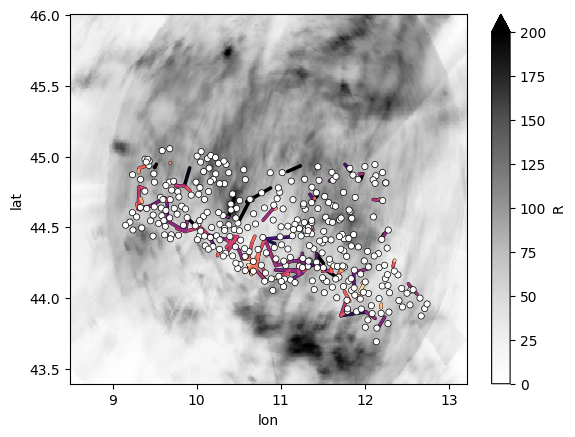

In [7]:
plg.plot_map.plot_plg(
    da_cmls=ds_cmls.rsl.isel(sublink_id=0).std(dim="time"),
    da_grid=ds_rad.R.resample(time="1h").sum().sum(dim="time"),
    # Note that the followoing line is just a quick hack to not
    # show rainfall data of the gauges on the map, since this plotting
    # function  here can not yet just plot one dataset with a fixed color.
    da_gauges=ds_gauges.rainfall_amount.sum(dim="time") > 0,
    cmap="Grays",
    vmin=0,
    vmax=200,
    kwargs_cmls_plot={
        "edge_color": "k",
        "edge_width": 0.5,
        "vmin": 0,
        "vmax": 5,
        "cmap": "magma_r",
    },
)

## Amsterdam PWS data
This dataset is based on [de Vos et al. (2019)](https://data.4tu.nl/articles/dataset/Rainfall_observations_datasets_from_Personal_Weather_Stations/12703250) and includes 134 PWS over 25 month in the region of Amsterdam. Addtionally there is reference dataset prepared by Abbas El Hachem that is based on openly availably radar data from KNMI. He used  20 random pixels within the area of the AMS PWS dataset and parsed them to a gauge-like reference dataset that is now available alongside the PWS data.

In [8]:
(
    ds_pws,
    ds_gauges,
) = plg.example_data.load_ams_pws(data_dir="example_data", subset="full_period")

File already exists at example_data/ams_pws_full_period.nc
Not downloading!
File already exists at example_data/ams_gauges_full_period.nc
Not downloading!


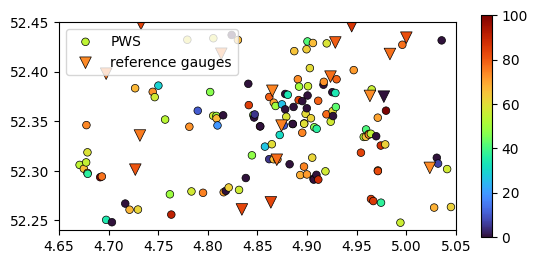

In [9]:
fig, ax = plt.subplots()
pws_plot = plg.plot_map.plot_plg(
    da_gauges=ds_pws.sel(time="2018-04").rainfall.sum(dim="time"),
    vmin=0,
    vmax=100,
    kwargs_gauges_plot={
        "s": 30,
        "label": "PWS",
    },
    ax=ax,
)
gauge_plot = plg.plot_map.plot_plg(
    da_gauges=ds_gauges.sel(time="2018-04").rainfall.sum(dim="time"),
    vmin=0,
    vmax=100,
    kwargs_gauges_plot={
        "s": 70,
        "marker": "v",
        "label": "reference gauges",
    },
    ax=ax,
)
# Note: poligrain right now does not support plotting of a colorbar
# for point or line plots. hence  the usage of plt.imshow is a hack
# to generate a mappable for plt.colorbar.
plt.imshow([[0]], vmin=0, vmax=100, cmap="turbo")
ax.set_xlim(4.65, 5.05)
ax.set_ylim(52.24, 52.45)
plt.colorbar(shrink=0.6)
plt.legend()